# Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assur-
ance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two dierent tests. From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/ex2data2.txt', header=None, names=['test1', 'test2','accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
X = df.drop('accepted', axis=1).values
y = df['accepted'].values.reshape(-1,1)

# EDA

In [4]:
def plotData(X, y):
    y = y.flatten()
    pos, neg = (y==1), (y==0)
    x1, x2 = X[:,0], X[:,1]
    plt.figure(figsize=(8,8))
    plt.plot(X[pos,0], X[pos,1], 'k+', linewidth=2, markersize=8, label='Accepted')
    plt.plot(X[neg,0], X[neg,1], 'yo', markersize=8, label='Not accepted')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend();

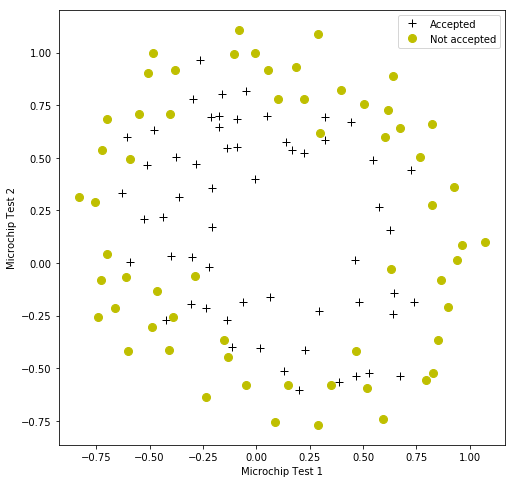

In [5]:
plotData(X,y)

The plot shows that our dataset cannot be separated into positive and
negative examples by a straight-line through the plot. Therefore, a straight-
forward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

## Feature mapping

One way to fit the data better is to **create more features** from each data
point.<br>
We will **map the features into all polynomial terms of x1 and x2 up to the sixth power.**


$$ mapFeature(x) = 
\begin{bmatrix}
    1 \\
    x_1 \\
    x_2 \\
    x_1^2 \\
    x_1x_2 \\
    x_2^2 \\
    x_1^3 \\
    \vdots \\
    x_1x_2^5 \\
    x_2^6
\end{bmatrix}
$$

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classier,
it also more susceptible to overtting. In the next parts of the exercise, you
will implement regularized logistic regression to t the data and also see for
yourself how regularization can help combat the overtting problem.

In [6]:
def mapFeature(x1, x2, degree):
    out = np.ones((len(x1),1))
    for i in np.arange(degree) + 1:
        for j in np.arange(i+1):
            out = np.hstack([out, (x1**(i-j)) * (x2**j)])
    return out

In [7]:
x1 = X[:,0].reshape(-1,1)
x2 = X[:,1].reshape(-1,1)

X = mapFeature(x1,x2, degree=6)
m, n = X.shape

print(X)

[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01 ...  6.29470940e-04
   8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01 ...  1.89305413e-03
  -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.92250000e-01 ...  1.04882142e-02
  -3.39734512e-02  1.10046893e-01]
 ...
 [ 1.00000000e+00 -4.84450000e-01  9.99270000e-01 ...  2.34007252e-01
  -4.82684337e-01  9.95627986e-01]
 [ 1.00000000e+00 -6.33640000e-03  9.99270000e-01 ...  4.00328554e-05
  -6.31330588e-03  9.95627986e-01]
 [ 1.00000000e+00  6.32650000e-01 -3.06120000e-02 ...  3.51474517e-07
  -1.70067777e-08  8.22905998e-10]]


## Cost function and gradient

**Cost**<br>
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[ -y^{(i)}log(h_\theta(x^{(i)})) - (1 - y^{(i)})log(1 - h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$$

**Gradients**<br>
$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$    for j = 0

$\frac{\partial J(\theta)}{\partial \theta_j} = (\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m}\theta_j$    for j >= 1

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def costFunctionReg(theta, X, y, l):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    # compute hypothesis h(x)
    h = sigmoid(X @ theta)
    
    # theta 0 is not regularized
    J = -1/m * np.sum(y*np.log(h) + (1-y)*np.log(1-h)) \
        + l/(2*m) * np.sum(theta[1:]**2)
        
    return J


def gradientFunctionReg(theta, X, y, l):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    # compute hypothesis h(x)
    h = sigmoid(X @ theta)
    
    grad = np.zeros((X.shape[1], 1))
    # compute gradient for theta 0 (not regularized)
    grad[0,0] = 1/m * np.sum(h - y)

    # compute gradients (theta_0, ... theta_n)
    grad[1:] = (np.transpose(X[:,1:]) @ (h-y))/m + (l/m * theta[1:])
    
    return grad.flatten()

In [9]:
# Initialize fitting parameters
initial_theta = np.zeros(n)
# lambda = 1
l = 1

cost = costFunctionReg(initial_theta, X, y, l)
grad = gradientFunctionReg(initial_theta, X, y, l)

print('Cost at initial theta (zeros): {}'.format(cost))
print('Expected cost (approx): 0.693');
print(
    'Gradient at initial theta (zeros):\n[{g[0]:.5f} {g[1]:.5f} {g[2]:.5f} {g[3]:.5f} {g[4]:.5f} ...]'
    .format(g=grad))
print('Expected gradients (approx):\n[0.0085 0.0188 0.0001 0.0503 0.0115 ...]')

Cost at initial theta (zeros): 0.6931471805599454
Expected cost (approx): 0.693
Gradient at initial theta (zeros):
[0.00847 0.01879 0.00008 0.05034 0.01150 ...]
Expected gradients (approx):
[0.0085 0.0188 0.0001 0.0503 0.0115 ...]


In [10]:

test_theta = np.ones(n)
# lambda = 10
l = 10

cost = costFunctionReg(test_theta, X, y, l)
grad = gradientFunctionReg(test_theta, X, y, l)

print('Cost at test theta (lambda = 10): {}'.format(cost))
print('Expected cost (approx): 3.16');
print(
    'Gradient at test theta (zeros):\n[{g[0]:.5f} {g[1]:.5f} {g[2]:.5f} {g[3]:.5f} {g[4]:.5f} ...]'
    .format(g=grad))
print('Expected gradients (approx):\n[0.3460 0.1614 0.1948 0.2269 0.0922 ...]')

Cost at test theta (lambda = 10): 3.1645093316150095
Expected cost (approx): 3.16
Gradient at test theta (zeros):
[0.34605 0.16135 0.19480 0.22686 0.09219 ...]
Expected gradients (approx):
[0.3460 0.1614 0.1948 0.2269 0.0922 ...]


## Regularization and Accuracies

In [11]:
from scipy.optimize import minimize

# Initialize fitting parameters
initial_theta = np.zeros(n)
# lambda = 1
l = 1

result = minimize(fun = costFunctionReg,
                 x0 = initial_theta,
                 args = (X, y, l),
                 method = 'TNC',
                 jac = gradientFunctionReg)
result

     fun: 0.5290027299645002
     jac: array([-2.15004804e-06,  6.79563916e-07, -3.48903228e-07,  8.76168500e-07,
       -4.08094898e-08, -9.33373610e-07, -5.14435485e-07,  1.70913400e-08,
        1.55580134e-08, -9.72584166e-07,  6.97049617e-08,  3.55341225e-08,
       -2.79486875e-07,  1.79704525e-07,  2.33384138e-07,  1.47214008e-07,
       -2.11821415e-07,  6.16752381e-07, -9.28292367e-08, -5.27386256e-08,
       -1.48154606e-06,  2.31318088e-07,  1.80340971e-07, -1.31777371e-07,
       -7.16937653e-08, -4.12299766e-07,  1.65638413e-08, -7.34752413e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 32
     nit: 7
  status: 1
 success: True
       x: array([ 1.27271027,  0.62529965,  1.18111686, -2.01987399, -0.91743189,
       -1.43166929,  0.12393227, -0.36553118, -0.35725403, -0.17516292,
       -1.45817009, -0.05098418, -0.61558554, -0.27469165, -1.19271298,
       -0.24217841, -0.20603299, -0.04466178, -0.2777895 , -0.29539513,
       -0.45645982, -1.04319155,  0.027793

In [12]:
theta = result.x
print('Cost: {}'.format(result.fun))
print('Theta: {}'.format(theta))

Cost: 0.5290027299645002
Theta: [ 1.27271027  0.62529965  1.18111686 -2.01987399 -0.91743189 -1.43166929
  0.12393227 -0.36553118 -0.35725403 -0.17516292 -1.45817009 -0.05098418
 -0.61558554 -0.27469165 -1.19271298 -0.24217841 -0.20603299 -0.04466178
 -0.2777895  -0.29539513 -0.45645982 -1.04319155  0.02779373 -0.2924487
  0.0155576  -0.32742405 -0.1438915  -0.92467487]


### Plot decision boundary

In [13]:
def plotDecisionBoundary(theta):
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)

    z = np.zeros((len(u), len(v)))
    # Evaluate z = theta*x over the grid
    for i in np.arange(len(u)):
        for j in np.arange(len(v)):
            z[i,j] = np.asscalar(
                mapFeature(np.mat(u[i]),np.mat(v[j]), degree=6) @ theta.reshape(-1,1))
    z = np.transpose(z)
    plt.contour(u, v, z, 0)

#### Decision Boundary: $\lambda = 1$

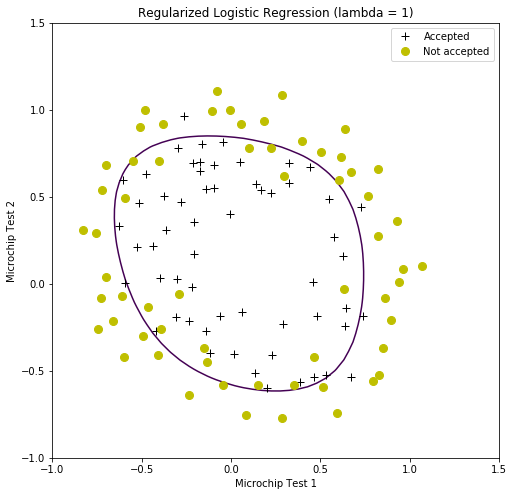

In [14]:
plot_xy = df.drop('accepted', axis=1).values

plotData(plot_xy, y)
plotDecisionBoundary(theta)
plt.title('Regularized Logistic Regression (lambda = 1)');

### Predict on the training set

In [15]:
# Predict
p = sigmoid(X @ theta.reshape(-1,1)) >= 0.5

# Compute accuracy
print('Train Accuracy: {}'.format( np.mean(p==y)))
print('Expected Accuracy (lambdb = 1): 83.1 (approx)')

Train Accuracy: 0.8305084745762712
Expected Accuracy (lambdb = 1): 83.1 (approx)


#### Decision Boundary: $\lambda = 0$ (No regularization & Overfitting)

In [16]:
# lambda = 0
l = 0

result = minimize(fun = costFunctionReg,
                 x0 = initial_theta,
                 args = (X, y, l),
                 method = 'TNC',
                 jac = gradientFunctionReg)

print('Cost: {}'.format(result.fun))
print('Theta: {}'.format(result.x))

Cost: 0.2515905956894092
Theta: [   14.43522364    19.59179015     4.74200134  -152.64379677
   -86.89586094   -61.39578737  -156.62885633  -116.0037656
   -65.15562291    10.96674577   546.98382421   518.55680572
   646.55370852   287.20877488    79.54793752   281.79009236
   372.5415773    446.44062688   245.93092979    87.10244271
   -11.66724644  -643.5175828   -842.69120664 -1238.04077014
  -969.84447707  -859.55478969  -336.00749661   -45.97373782]


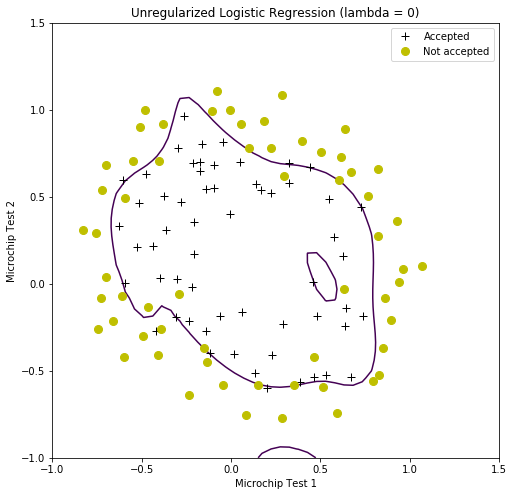

In [17]:
plotData(plot_xy, y)
plotDecisionBoundary(result.x)
plt.title('Unregularized Logistic Regression (lambda = 0)');

In [18]:
p = sigmoid(X @ result.x.reshape(-1,1)) >= 0.5

# Compute accuracy
print('Train Accuracy: {}'.format( np.mean(p==y)))

Train Accuracy: 0.8728813559322034


#### Decision Boudnary: $\lambda = 100$ (Too much regularization & Underfitting)

In [19]:
# lambda = 100
l = 100

result = minimize(fun = costFunctionReg,
                 x0 = initial_theta,
                 args = (X, y, l),
                 method = 'TNC',
                 jac = gradientFunctionReg)
print('Cost: {}'.format(result.fun))
print('Theta: {}'.format(result.x))

Cost: 0.6864838338727015
Theta: [ 0.02187847 -0.0174817   0.00571065 -0.05516901 -0.01314874 -0.03859873
 -0.01846356 -0.00773219 -0.00892429 -0.02280461 -0.04343846 -0.00235623
 -0.01415612 -0.00349507 -0.04143595 -0.02100593 -0.00471917 -0.00359131
 -0.00632226 -0.0050244  -0.03197683 -0.03416334 -0.00107629 -0.00702615
 -0.00038507 -0.0079823  -0.00154779 -0.04108683]


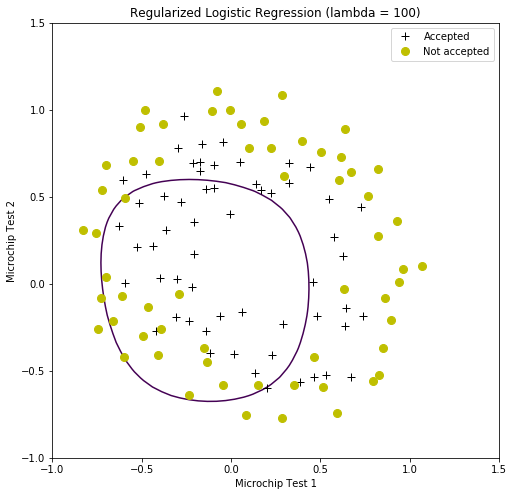

In [20]:
plotData(plot_xy, y)
plotDecisionBoundary(result.x)
plt.title('Regularized Logistic Regression (lambda = 100)');

In [21]:
p = sigmoid(X @ result.x.reshape(-1,1)) >= 0.5

# Compute accuracy
print('Train Accuracy: {}'.format( np.mean(p==y)))

Train Accuracy: 0.6101694915254238
